In [19]:
import torch
import kagglehub
import pandas as pd

from torch.utils.data import DataLoader, Dataset

In [6]:
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Path to dataset files:", path)
df = pd.read_csv(path + "/IMDB Dataset.csv")

Path to dataset files: /home/felix/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<Axes: xlabel='sentiment'>

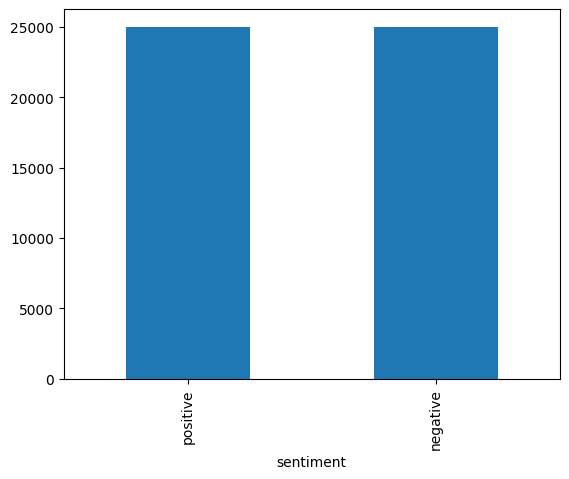

In [11]:
df["sentiment"].value_counts().plot(kind="bar")

In [13]:
phrase_length = df["review"].apply(len).value_counts()

<Axes: ylabel='Frequency'>

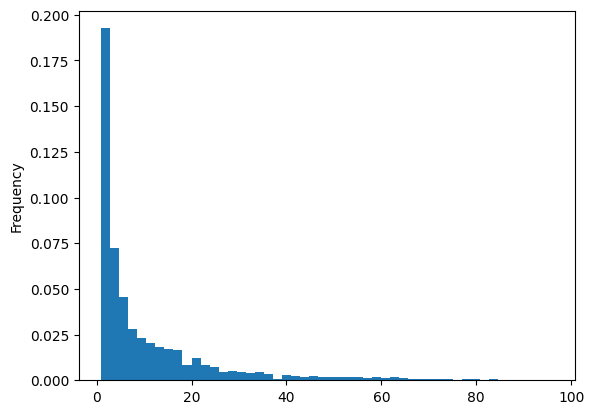

In [16]:
phrase_length.plot(kind="hist", bins=50, density=True)

In [ ]:
train, test = torch.utils.data.random_split(df, [0.8, 0.2])
train, val = torch.utils.data.random_split(train, [0.8, 0.2])

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, frame):
        self.texts = frame["review"].tolist()
        self.labels = (
            frame["sentiment"]
            .map({"negative": 0, "positive": 1})
            .astype("int64")
            .tolist()
        )

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], torch.tensor(self.labels[idx], dtype=torch.long)


train_ds = IMDBDataset(train)
val_ds = IMDBDataset(val)
test_ds = IMDBDataset(test)


train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds)
test_loader = DataLoader(test_ds)

TypeError: list indices must be integers or slices, not str

In [22]:
test_texts, test_labels = next(iter(test_loader))

NameError: name 'test_loader' is not defined